In [1]:
# Here I'm trying to load in a file (let's try sea ice concentration),
# starting from the code in hello_world.ipynb
%matplotlib inline
import warnings
warnings.simplefilter("ignore")
import xarray as xr
import intake
import numpy as np
import matplotlib.pyplot as plt

# specific plotting stuff from Lettie
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy.ma as ma

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util
import xesmf as xe

In [2]:
# Use intake-esm to find a model and experiment
# Access the pangeo cmip6 archive
col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
#col.df.head() # this shows the fields that are available for querying

# query the archive to see what models, experiments, output, etc.
# frequencies are available
import pprint 
uni_dict = col.unique(['experiment_id'])
pprint.pprint(uni_dict, compact=True)

# find a specific experiment, output frequency, variable, and grid
cat = col.search(experiment_id=['historical'], table_id=['SImon'], variable_id=['siconc'], grid_label=['gn'])
#cat.df

# using intake-esm, create a 'dictionary' of the files that I can then individually query
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': False})
dset_dict.keys() # list the files

{'experiment_id': {'count': 29,
                   'values': ['ssp370', 'esm-ssp585', '1pctCO2-bgc', 'hist-bgc',
                              '1pctCO2', 'abrupt-4xCO2', 'historical',
                              'piControl', 'amip', 'esm-hist', 'esm-piControl',
                              'hist-GHG', 'hist-aer', 'hist-nat', 'dcppA-assim',
                              'dcppA-hindcast', 'dcppC-hindcast-noAgung',
                              'dcppC-hindcast-noElChichon',
                              'dcppC-hindcast-noPinatubo', 'highresSST-present',
                              'control-1950', 'hist-1950', 'deforest-globe',
                              'esm-ssp585-ssp126Lu', 'omip1', 'lgm', 'ssp126',
                              'ssp245', 'ssp585']}}
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 18 group(s)


dict_keys(['CMIP.CAMS.CAMS-CSM1-0.historical.SImon.gn', 'CMIP.CCCma.CanESM5.historical.SImon.gn', 'CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.SImon.gn', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.SImon.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3.historical.SImon.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.SImon.gn', 'CMIP.IPSL.IPSL-CM6A-LR.historical.SImon.gn', 'CMIP.MIROC.MIROC-ES2L.historical.SImon.gn', 'CMIP.MIROC.MIROC6.historical.SImon.gn', 'CMIP.MOHC.HadGEM3-GC31-LL.historical.SImon.gn', 'CMIP.MOHC.UKESM1-0-LL.historical.SImon.gn', 'CMIP.MRI.MRI-ESM2-0.historical.SImon.gn', 'CMIP.NCAR.CESM2.historical.SImon.gn', 'CMIP.NCAR.CESM2-WACCM.historical.SImon.gn', 'CMIP.NCC.NorCPM1.historical.SImon.gn', 'CMIP.NOAA-GFDL.GFDL-CM4.historical.SImon.gn', 'CMIP.NUIST.NESM3.historical.SImon.gn', 'CMIP.SNU.SAM0-UNICON.historical.SImon.gn'])

0
Reuse existing file: bilinear_200x360_161x361_peri.nc
1
Reuse existing file: bilinear_291x360_161x361_peri.nc
2
Reuse existing file: nearest_s2d_294x362_161x361_peri.nc
3
Reuse existing file: nearest_s2d_294x362_161x361_peri.nc
4
Reuse existing file: nearest_s2d_292x362_161x361_peri.nc
5
Reuse existing file: nearest_s2d_292x362_161x361_peri.nc
6
Reuse existing file: nearest_s2d_332x362_161x361_peri.nc
7
Reuse existing file: bilinear_256x360_161x361_peri.nc
8
Reuse existing file: bilinear_256x360_161x361_peri.nc
9
Reuse existing file: bilinear_330x360_161x361_peri.nc
10
Reuse existing file: bilinear_330x360_161x361_peri.nc
11
Reuse existing file: bilinear_363x360_361x161_peri.nc
12
Reuse existing file: bilinear_384x320_361x161_peri.nc
13
Reuse existing file: bilinear_384x320_361x161_peri.nc
14
Reuse existing file: bilinear_384x320_361x161_peri.nc
15
Reuse existing file: bilinear_1080x1440_161x361_peri.nc
16
Reuse existing file: bilinear_384x320_361x161_peri.nc
17
Reuse existing file: 

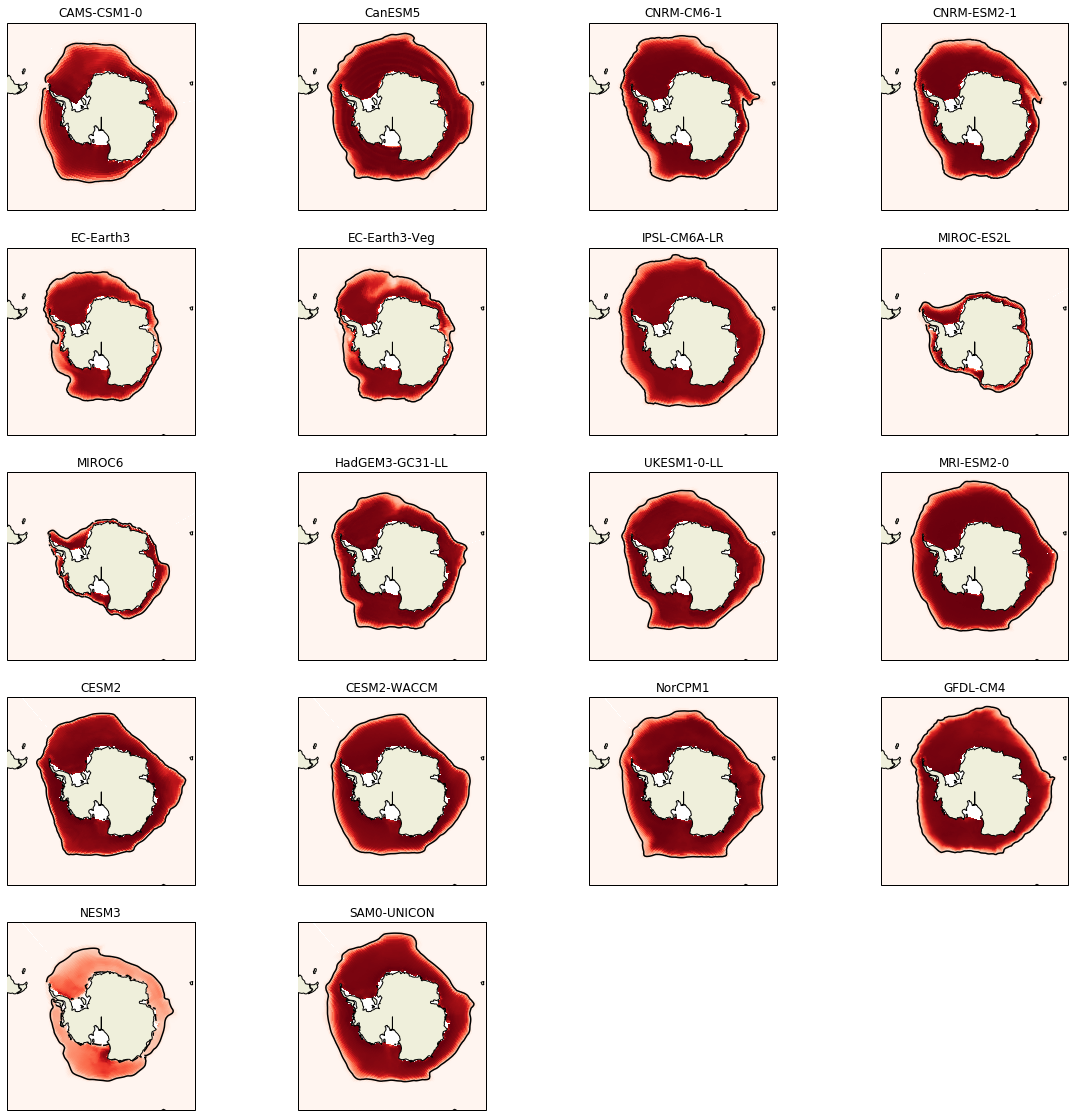

In [3]:
# Time info for calculating a climatology: all models' historical runs' output
# begins on January 1850, so figure out the indices that correspond to the months
# you want to average
year_start = 1986
nyears = 10 # number of years, beginning on year_start, to make the climatology for
clim_month = 7 # the month to make the climatology for (0: January)
months = clim_month+12*np.arange(nyears) + 12*(year_start-1850) # the indices to be used later

# New evenly spaced, monotonically increasing lat-lon grid for regridding the sea ice
# concentration for the contour plot (otherwise the contour will reverse on itself)
res_new = 1 #degrees; the resolution of the new grid
lat_new = -80 + np.arange(1+(2*80)/res_new) # only go from 80S to 80N
lon_new = np.arange(1+(360)/res_new)
lon_new, lat_new = np.meshgrid(lon_new,lat_new)

ice_edge_conc = 15 # the concentration threshold for the sea ice edge
index = 0 # dummy index
fig = plt.figure(figsize=(20,20))
for i in dset_dict:
    print(index) # to make sure the calculation hasn't stalled
    
    # Deal with diferent names for latitude and longitude coordinates
    if 'latitude' in dset_dict[i]:
        latitude = dset_dict[i].latitude
        longitude = dset_dict[i].longitude
    elif 'lat' in dset_dict[i]:
        latitude = dset_dict[i].lat
        longitude = dset_dict[i].lon
    else:
        latitude = dset_dict[i].nav_lat
        longitude = dset_dict[i].nav_lon
        
    # Deal with multiple ensemble members, 1D grid vectors
    if latitude.ndim==3:
        latitude = np.squeeze(np.array(latitude[0,:,:]))
        longitude = np.squeeze(np.array(longitude[0,:,:]))
        nlat = np.size(latitude, axis=0)
        nlon = np.size(longitude, axis=1)
    elif latitude.ndim==2:
        latitude = np.array(latitude)
        longitude = np.array(longitude)
        nlat = np.size(latitude, axis=0)
        nlon = np.size(longitude, axis=1)
    else:
        nlat = np.size(latitude)
        nlon = np.size(longitude)
        latitude = np.tile(latitude,(nlon,1)).swapaxes(0,1)
        longitude = np.tile(longitude,(nlat,1))
        
    # Load in the sea ice concentration for the months I want,
    # average it over those months, and find its size
    data = dset_dict[i].siconc[0,months,:,:].mean(dim='time')
    data = np.squeeze(np.array(data))
    ndim0 = np.size(data,axis=0)
    ndim1 = np.size(data,axis=1)
    
    # Regrid
    data_new = data
    lat_temp = latitude.copy()
    lon_temp = longitude.copy()
    method = np.str('bilinear')
    # Make method exceptions for models with weird grids around antarctica
    if dset_dict[i].source_id == 'CNRM-CM6-1':
        method = np.str('nearest_s2d')
    elif dset_dict[i].source_id == 'CNRM-ESM2-1':
        method = np.str('nearest_s2d')
    elif dset_dict[i].source_id == 'EC-Earth3':
        method = np.str('nearest_s2d')
    elif dset_dict[i].source_id == 'EC-Earth3-Veg':
        method = np.str('nearest_s2d')
    elif dset_dict[i].source_id == 'IPSL-CM6A-LR':
        method = np.str('nearest_s2d')
    # Make sure the dimensions of the new grid are in the right order
    lat_temp = lat_new.copy()
    lon_temp = lon_new.copy()
    if ndim0>ndim1:
        lat_temp = np.transpose(lat_temp)
        lon_temp = np.transpose(lon_temp)
    lat_temp2 = latitude.copy()
    lon_temp2 = longitude.copy()
    lat_temp2[np.abs(lat_temp2)>90] = np.nan
    lon_temp2[np.abs(lon_temp2)>360] = np.nan
    # Create the xarray datasets to feed into the xesmf regridder
    ds_in = xr.Dataset({'lat': (['x','y'],lat_temp2),
                        'lon': (['x','y'],lon_temp2)})
    ds_out = xr.Dataset({'lat': (['x','y'],lat_temp),
                            'lon': (['x','y'],lon_temp)})
    # Regrid the data
    f = xe.Regridder(ds_in, ds_out, method, periodic=True, reuse_weights=True)
    data_new = f(data)
    
    # A data mask for SouthPolarStereo plots
    mydata = ma.masked_where(latitude>0.,data.copy())
    mydata_new = ma.masked_where(lat_temp>0.,data_new.copy())
    
    # Make a pcolor plot of sea ice concentration, and contour the sea ice edge
    ax = plt.subplot(5,4,index+1,projection = ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree())
    this = ax.pcolormesh(longitude,latitude,mydata,transform=ccrs.PlateCarree(),cmap = plt.cm.Reds, vmin=0, vmax=100)
    this2 = ax.contour(lon_temp,lat_temp,mydata_new,[ice_edge_conc],transform=ccrs.PlateCarree(),colors='k')
    plt.title(np.str(dset_dict[i].source_id))
    
    index = index+1